In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from time import time

In [51]:
df = pd.read_csv("../data/MSFT_complete.csv", parse_dates = True, index_col = 'Date')
del df['Unnamed: 0']
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-09-21,25.110001,25.370001,25.100000,25.299999,19.717058,28878700
2009-09-22,25.400000,25.820000,25.290001,25.770000,20.083347,61376700
2009-09-23,25.920000,26.250000,25.639999,25.709999,20.036585,60599900
2009-09-24,25.920000,26.110001,25.660000,25.940001,20.215834,56302900
2009-09-25,25.690001,25.820000,25.520000,25.549999,19.911896,50158900
...,...,...,...,...,...,...
2020-05-24,183.190002,184.460007,182.539993,183.509995,183.509995,20826900
2020-05-25,183.190002,184.460007,182.539993,183.509995,183.509995,20826900
2020-05-26,186.339996,186.500000,181.100006,181.570007,181.570007,36073600


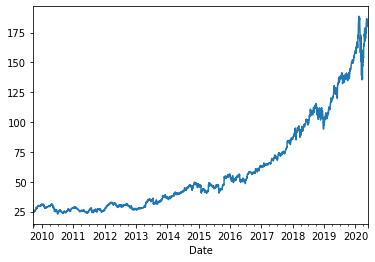

In [3]:
df['Close'].plot()

In [4]:
df.corr()['Close']

Open         0.999668
High         0.999806
Low          0.999784
Close        1.000000
Adj Close    0.999920
Volume      -0.324246
Name: Close, dtype: float64

In [5]:
df.drop(columns=['Volume','Adj Close'],inplace=True)

In [6]:
df.columns = [['open', 'high', 'low','close',]]
df

,open,high,low,close
Date,,,,
2009-09-21,25.110001,25.370001,25.100000,25.299999
2009-09-22,25.400000,25.820000,25.290001,25.770000
2009-09-23,25.920000,26.250000,25.639999,25.709999
2009-09-24,25.920000,26.110001,25.660000,25.940001
2009-09-25,25.690001,25.820000,25.520000,25.549999
...,...,...,...,...
2020-05-24,183.190002,184.460007,182.539993,183.509995
2020-05-25,183.190002,184.460007,182.539993,183.509995
2020-05-26,186.339996,186.500000,181.100006,181.570007


In [7]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [8]:
data = sc.fit_transform(df)

In [9]:
data

array([[0.01205539, 0.01224759, 0.01447417, 0.01382099],
       [0.01378611, 0.01493607, 0.01563455, 0.01665761],
       [0.01688947, 0.01750508, 0.01777207, 0.01629549],
       ...,
       [0.97427788, 0.97490741, 0.96720413, 0.95696789],
       [0.9376343 , 0.94796277, 0.93972154, 0.95841632],
       [0.94085707, 0.96086747, 0.96280691, 0.9559418 ]])

In [36]:
train_ind = int(0.8*len(df))
# val_ind = train_ind + int(0.2*len(df))

In [37]:
train = data[:train_ind]
# val = data[train_ind:val_ind]
test = data[train_ind:]

In [38]:
train.shape, test.shape

((3122, 4), (781, 4))

In [39]:
xtrain,ytrain,xtest,ytest = train[:,:4],train[:,3],test[:,:4],test[:,3]
xtrain.shape, ytrain.shape, 

((3122, 4), (3122,))

In [40]:
lookback = 60
n_features = 4
output_dim = 4
train_len = len(xtrain) - lookback
test_len = len(xtest) - lookback
# val_len = len(xval) - lookback

In [41]:
x_train = np.zeros((train_len, lookback, n_features))
y_train = np.zeros((train_len))
for i in range(train_len):
    ytemp = i+lookback
    x_train[i] = xtrain[i:ytemp]
    y_train[i] = ytrain[ytemp]
print("x_train", x_train.shape)
print("y_train", y_train.shape)

x_train (3062, 60, 4)
y_train (3062,)


In [42]:
x_test = np.zeros((test_len, lookback, n_features))
y_test = np.zeros((test_len))
for i in range(test_len):
    ytemp = i+lookback
    x_test[i] = xtest[i:ytemp]
    y_test[i] = ytest[ytemp]
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_test (721, 60, 4)
y_test (721,)


In [17]:
# x_val = np.zeros((val_len, lookback, n_features))
# y_val = np.zeros((val_len))
# for i in range(val_len):
#     ytemp = i+lookback
#     x_val[i] = xval[i:ytemp]
#     y_val[i] = yval[ytemp]
# print("x_val", x_val.shape)
# print("y_val", y_val.shape)


x_val (720, 60, 4)
y_val (720,)


In [43]:
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import LSTM
from keras.optimizers import Adam
from time import time
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

In [44]:
model = Sequential() 
model.add(LSTM(120,input_shape = (lookback, n_features), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))

In [45]:
model.compile(loss = 'mse', optimizer = 'adam')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')

In [46]:
start = time()
print("start:",0)
model.fit(x_train,y_train, epochs = 50, batch_size=30, 
          validation_data=(x_test,y_test),verbose = 1, 
          shuffle = False, callbacks=[earlystop])
print("end:",time()-start)

start: 0
Train on 3062 samples, validate on 721 samples
Epoch 1/50
3062/3062 [==============================] - 12s 4ms/step - loss: 2.1508e-04 - val_loss: 0.0085
Epoch 2/50
3062/3062 [==============================] - 10s 3ms/step - loss: 2.0548e-04 - val_loss: 0.0120
Epoch 3/50
3062/3062 [==============================] - 10s 3ms/step - loss: 3.4567e-04 - val_loss: 0.0218
Epoch 4/50
3062/3062 [==============================] - 10s 3ms/step - loss: 5.4831e-04 - val_loss: 0.0333
Epoch 5/50
3062/3062 [==============================] - 10s 3ms/step - loss: 7.0610e-04 - val_loss: 0.0393
Epoch 6/50
3062/3062 [==============================] - 10s 3ms/step - loss: 8.6679e-04 - val_loss: 0.0494
Epoch 7/50
3062/3062 [==============================] - 10s 3ms/step - loss: 0.0011 - val_loss: 0.0475
Epoch 8/50
3062/3062 [==============================] - 10s 3ms/step - loss: 0.0014 - val_loss: 0.0538
Epoch 9/50
3062/3062 [==============================] - 10s 3ms/step - loss: 0.0014 - val_loss: 

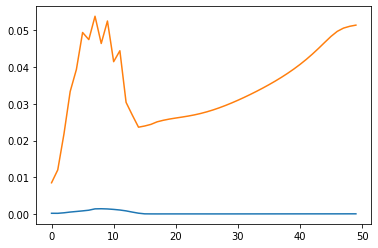

In [47]:
loss = model.history.history
plt.plot(loss['loss'])
plt.plot(loss['val_loss'])

In [48]:
y_pred = model.predict(x_test)

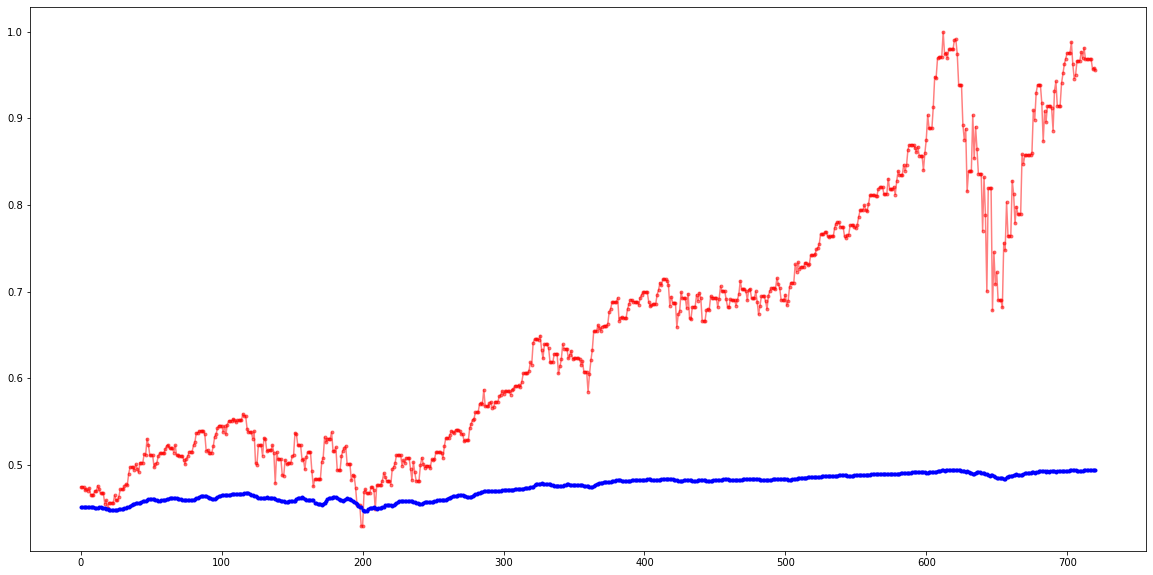

In [49]:

plt.figure(figsize=(20,10))
plt.plot( y_test, '.-', color='red', label='Real values', alpha=0.5)
plt.plot( y_pred, '.-', color='blue', label='Predicted values', alpha=1)

In [50]:
r2_score(y_pred,y_test)

-255.7537288996652

In [56]:
model.save("Testing_Hyper_paramters_11.h5")

In [57]:
from numpy import savetxt

In [58]:
savetxt('xtest.csv', x_test, delimiter=',')

ValueError: Expected 1D or 2D array, got 3D array instead